In [78]:
from pylab import *
import copy
import pandas as pd
import numpy as np
np.random.seed(0)

# 1) 
a)
**Utilizando exact line search para determinar el tamaño del paso. Genere matrices A y vectores b aleatorios de tamaño 20 × 4 y 20, respectivamente y resuelva el problema de cuadrados mínimos utilizando el algoritmo de gradiente descendente estocástico con minibatches de tamaño 1 y 2.**

b) Compare con la solución obtenida por el método de la pseudo-inversa. 

c) Estudie como varia la tasa de convergencia comparando los ratios ∥xk+1 − x∗∥/∥xk − x∗∥ para distintos tamaños de minibatches.

a) 

In the exact line‐search formula

$$
\alpha \;=\; -\frac{(A\,x - b)^\top d}{d^\top A\,d},
$$

\(d\) denotes the **search direction**, i.e.:

- For **steepest descent**: \(d = -\nabla f(x) = -(A\,x - b)\).  
- For **Newton’s method**: \(d\) solves \(A\,d = \nabla f(x)\).  

More generally, any descent direction \(d\) satisfying \(\nabla f(x)^\top d < 0\).  


In [79]:
def error(A, x, b):
    return 1/2*(A@x - b)@(A@x - b)

def grad_f(A, x, b):
    return A.T@(A@x - b)

def exact_line_search(A, b, x, grad):
    r = A @ x - b # r = Ax - b
    numerador = r.T @ A @ grad
    denominador = (A @ grad).T @ (A @ grad)
    return numerador / denominador if denominador != 0 else 0.0 

def exact_line_search(A, b, x, d):
    g = A @ x - b
    return -(g @ d) / (d @ (A @ d))

def get_alpha(A):
    eiganvalues = np.linalg.eigvals(A.T@A)
    lambda_max = max(eiganvalues)
    return 1/lambda_max

def get_alpha(*args):
    return 1e-2

In [80]:
#### Generación de datos
n_filas = 20 
n_columnas = 4

def generate_data(n_filas, n_columnas):
    np.random.seed(0)
    A = np.random.rand(n_filas, n_columnas)    # Datos
    x = np.random.rand(n_columnas)             # betas
    b = np.random.rand(n_filas)                # labels
    return A, x, b
A, x, b = generate_data(n_filas, n_columnas)

### Solucion por pseudoinversa
# Compute the SVD of A
U, s, VT = np.linalg.svd(A, full_matrices=False)

# Build the pseudoinverse of Sigma
Sigma_inv = np.diag(1/s)

# Compute the pseudoinverse solution for x
x_star = VT.T @ Sigma_inv @ U.T @ b # = A_pinv@b, donde A_pinv es pseudo inversa de A

# A_pinv = np.linalg.pinv(A)
# x = A_pinv@b

In [81]:
A, x, b = generate_data(n_filas, n_columnas)

# Hiperparámetros
Nsteps = 500
batch_size = 1

# Find alpha
alpha = get_alpha(A)

fk = []

# Iterate for each step
for i_step in range(Nsteps):

    # Iterate over each batch
    geval = np.zeros(n_columnas)
    for i_batch in range(batch_size):
        idx = np.random.choice(n_filas, size=1)
        ai, bi = A[idx], b[idx]
        pk = grad_f(ai, x, bi)
        geval = geval + pk
    
    geval = geval * 1/batch_size
    x = x - alpha*geval
    fk.append(error(A, x, b))

fk_sgd = copy.copy(fk)
print('Error: ', error(A, x, b))
print('Norma de x: ', np.sqrt(sum(x**2)))

Error:  0.9207039404968921
Norma de x:  0.55441385760822


b) Compare con la solución obtenida por el método de la pseudo-inversa. 

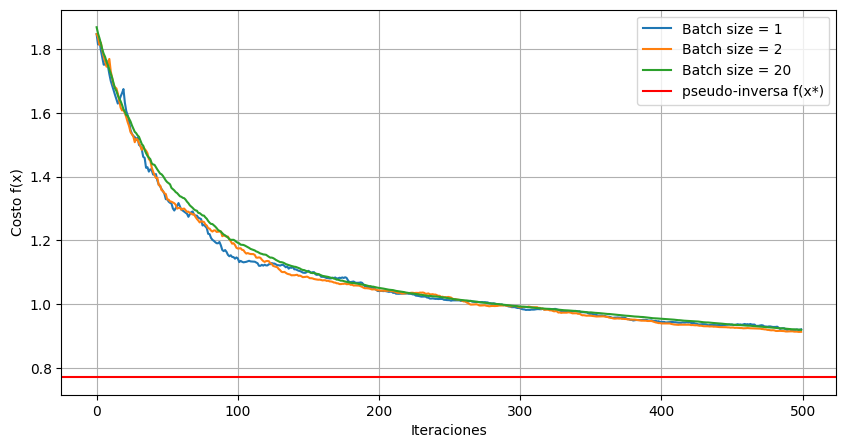

In [82]:
#### Dibujito

all_batch_sizes = [1,2,20]

convergencias = []
for batch_size in all_batch_sizes:
    A, x, b = generate_data(n_filas, n_columnas)

    # Hiperparámetros
    Nsteps = 500

    # Find alpha
    alpha = get_alpha(A)

    fk = []
    # Iterate for each step
    for i_step in range(Nsteps):

        # Iterate over each batch
        geval = np.zeros(n_columnas)
        for i_batch in range(batch_size):
            idx = np.random.choice(n_filas, size=1)
            ai, bi = A[idx], b[idx]
            geval += grad_f(ai, x, bi)
        geval *= 1/batch_size

        x = x - alpha*geval
        fk.append(error(A, x, b))

        convergencias.append({'batch_size': batch_size, 'step':i_step, 'error': fk[-1]})

convergencias = pd.DataFrame(convergencias)

plt.figure(figsize=(10, 5))
plt.plot(convergencias.query('batch_size==1').reset_index().error, label="Batch size = 1")
plt.plot(convergencias.query('batch_size==2').reset_index().error, label="Batch size = 2")
plt.plot(convergencias.query('batch_size==20').reset_index().error, label="Batch size = 20")
plt.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
plt.xlabel('Iteraciones')
plt.ylabel('Costo f(x)')
plt.legend()
plt.grid()
plt.show()

c) Estudie como varia la tasa de convergencia comparando los ratios ∥xk+1 − x∗∥/∥xk − x∗∥ para distintos tamaños de minibatches.

Error:  0.9197549995541303
Norma de x:  0.5260301445937886


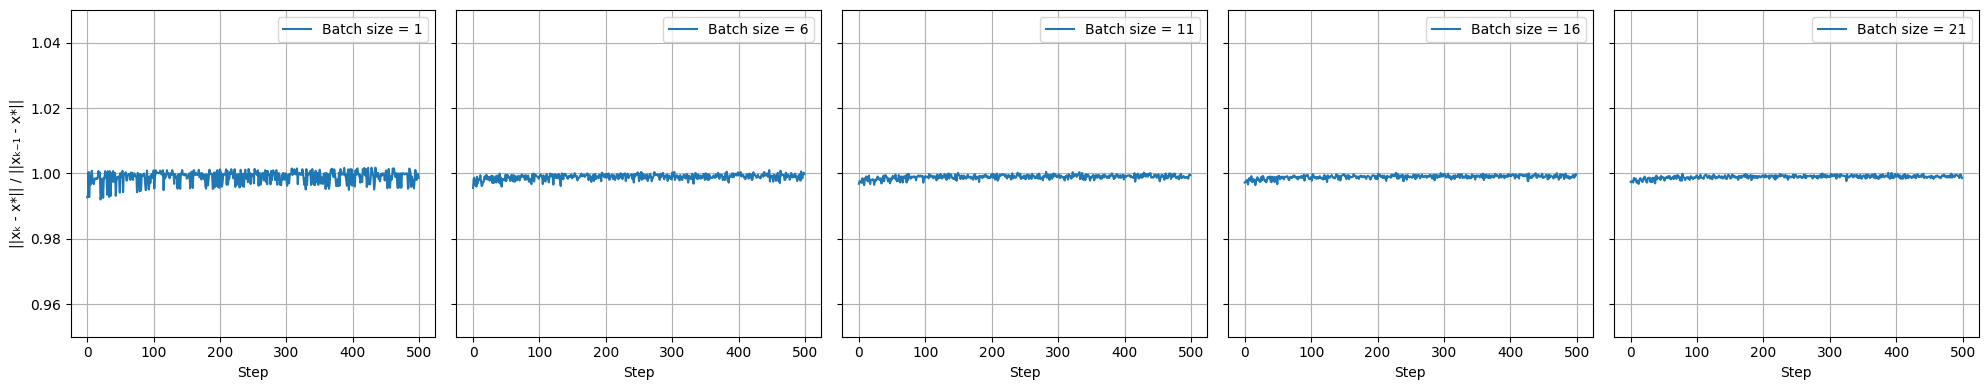

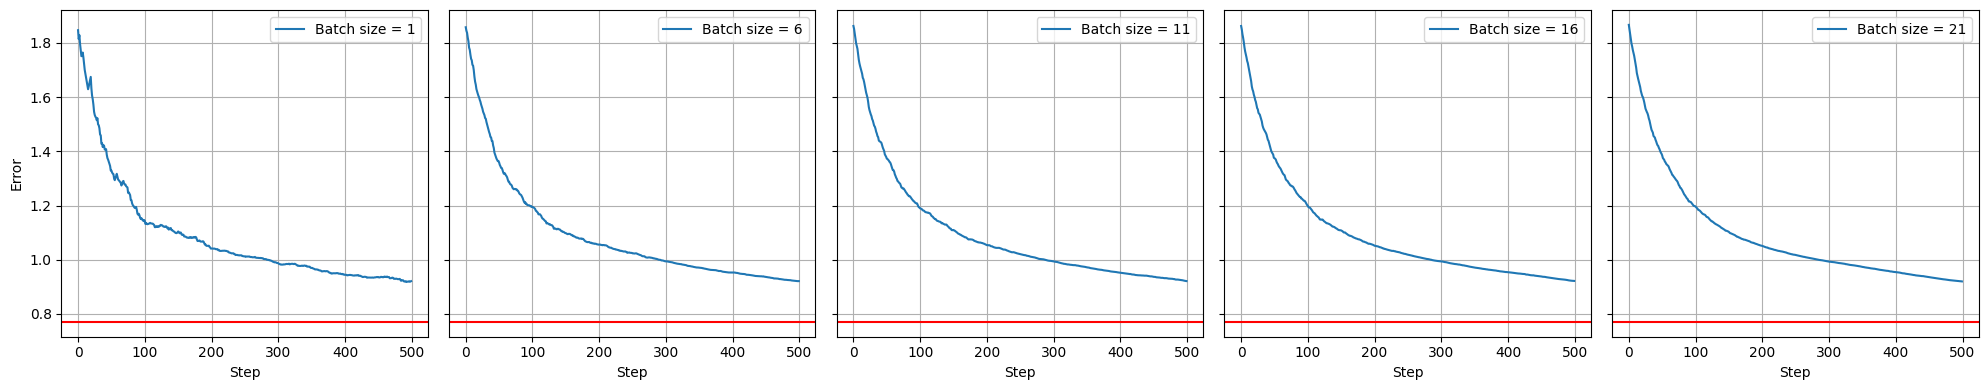

In [83]:
# Hiperparámetros
Nsteps = 500
all_batch_size = list(range(1, n_filas+2, 5))

# Find alpha
alpha = get_alpha(A)

ratios = []
for batch_size in all_batch_size:
    A, x, b = generate_data(n_filas, n_columnas)

    # Iterate for each step
    for i_step in range(Nsteps):
        last_x = x.copy()

        # Iterate over each batch
        geval = np.zeros(n_columnas)
        for i_batch in range(batch_size):
            idx = np.random.choice(n_filas, size=1)
            ai, bi = A[idx], b[idx]
            pk = grad_f(ai, x, bi)
            geval = geval + pk
        
        geval = geval * 1/batch_size
        x = x - alpha*geval
        fk.append(error(A, x, b))

        # ratio = ||xk - x*|| / ||xk-1 - x*||
        distance_k = np.linalg.norm(x-x_star)
        distance_k_minus_1 = np.linalg.norm(last_x-x_star)
        ratios.append({'batch_size':batch_size, 'step':i_step, 'ratio': distance_k / distance_k_minus_1, 'delta': distance_k - distance_k_minus_1, 'error':error(A, x, b)})

ratios = pd.DataFrame(ratios)
convergencias_sgd = ratios.copy()
print('Error: ', error(A, x, b))
print('Norma de x: ', np.sqrt(sum(x**2)))

# Plots
n = len(all_batch_size)

### A medida que aumenta batch size, disminuye la variabilidad de la convergencia.
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(4*n, 4), sharey=True)
for ax, batch_size in zip(axes, all_batch_size):
    data = (ratios
            .query('batch_size == @batch_size')
            .set_index('step')
            .ratio)
    ax.plot(data, label=f"Batch size = {batch_size}")
    ax.set_xlabel('Step')
    if ax is axes[0]:
        ax.set_ylabel('||xₖ - x*|| / ||xₖ₋₁ - x*||')
    ax.legend()
    ax.grid()
    ax.set_ylim(.95, 1.05)

plt.tight_layout()
plt.show()

### A medida que aumenta batch size, converge más rápido.
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(4*n, 4), sharey=True)
for ax, batch_size in zip(axes, all_batch_size):
    data = (ratios
            .query('batch_size == @batch_size')
            .set_index('step')
            .error)
    ax.plot(data, label=f"Batch size = {batch_size}")
    ax.set_xlabel('Step')
    if ax is axes[0]:
        ax.set_ylabel('Error')
    ax.legend()
    ax.grid()
    ax.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
    # ax.set_ylim(.95, 1.05)

plt.tight_layout()
plt.show()

# 2) 
Implemente los algortimos de ADAGRAD, RMSProp y/o Adam y repita el problema anterior.

### a.1) ADAGRAD

In [84]:
# Generación de datos
A, x, b = generate_data(n_filas, n_columnas)

# Hiperparámetros
Nsteps = 500
batch_size = 3

# Find alpha
alpha = get_alpha(A)

# Init variables
r = np.zeros(n_columnas)
fk = []

# Iterate for each step
for i_step in range(Nsteps):

    # Iterate over each batch
    geval = np.zeros(n_columnas)
    for i_batch in range(batch_size):
        idx = np.random.choice(n_filas, size=1)
        ai, bi = A[idx], b[idx]
        pk = grad_f(ai, x, bi)
        geval = geval + pk
    geval = geval * 1/batch_size

    # Update variables
    r += geval**2
    adapt_lr = alpha/(np.sqrt(r)+1e-8)
    x = x - adapt_lr * geval

    # Compute error
    fk.append(error(A, x, b))

print('Error: ', error(A, x, b))
print('Norma de a: ', np.sqrt(sum(x**2)))

Error:  0.9849958932922385
Norma de a:  0.5764653945419973


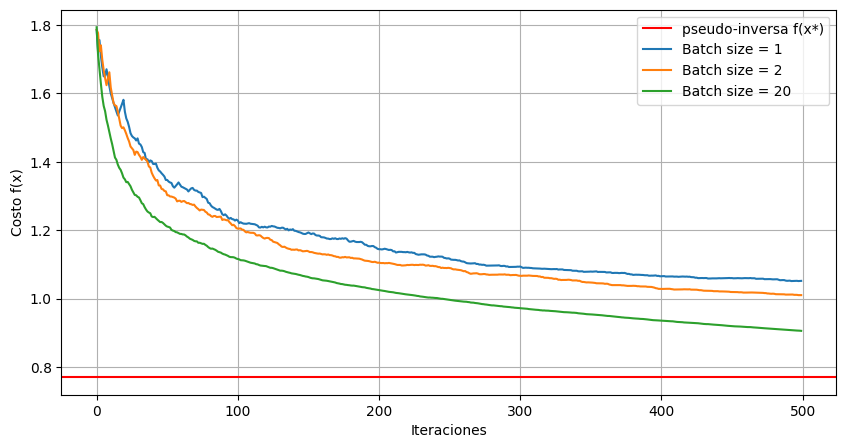

In [85]:
#### Dibujito

all_batch_sizes = [1,2,20]
convergencias = []
for batch_size in all_batch_sizes:

    # Generación de datos
    A, x, b = generate_data(n_filas, n_columnas)

    # Find alpha
    alpha = get_alpha(A)

    # Hiperparámetros
    Nsteps = 500

    # Init variables
    r = np.zeros(n_columnas)
    fk = []

    # Iterate for each step
    for i_step in range(Nsteps):

        # Iterate over each batch
        geval = np.zeros(n_columnas)
        for i_batch in range(batch_size):
            idx = np.random.choice(n_filas, size=1)
            ai, bi = A[idx], b[idx]
            pk = grad_f(ai, x, bi)
            geval = geval + pk
        geval = geval * 1/batch_size

        # Update variables
        r += geval**2
        adapt_lr = alpha/(np.sqrt(r)+.01)
        x = x - adapt_lr * geval

        # Compute error
        fk.append(error(A, x, b))

        convergencias.append({'batch_size': batch_size, 'step':i_step, 'error': fk[-1]})

convergencias = pd.DataFrame(convergencias)

plt.figure(figsize=(10, 5))
plt.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
plt.plot(convergencias.query('batch_size==1').reset_index().error, label="Batch size = 1")
plt.plot(convergencias.query('batch_size==2').reset_index().error, label="Batch size = 2")
plt.plot(convergencias.query('batch_size==20').reset_index().error, label="Batch size = 20")
plt.xlabel('Iteraciones')
plt.ylabel('Costo f(x)')
plt.legend()
plt.grid()
plt.show()

a.3) Estudie como varia la tasa de convergencia comparando los ratios ∥xk+1 − x∗∥/∥xk − x∗∥ para distintos tamaños de minibatches.

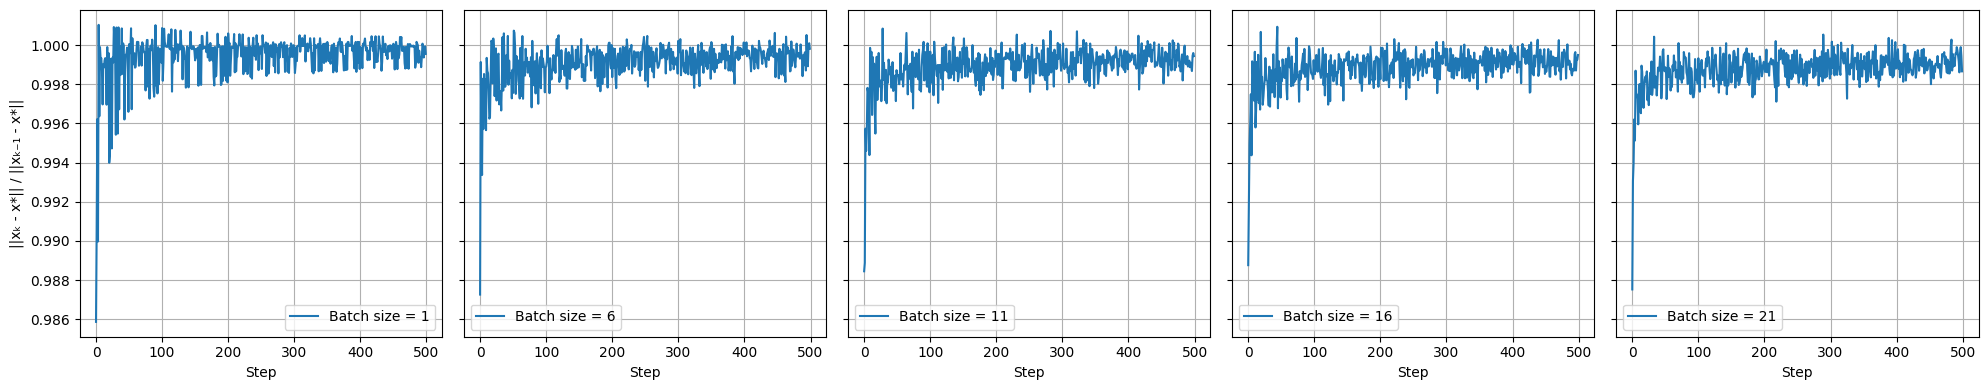

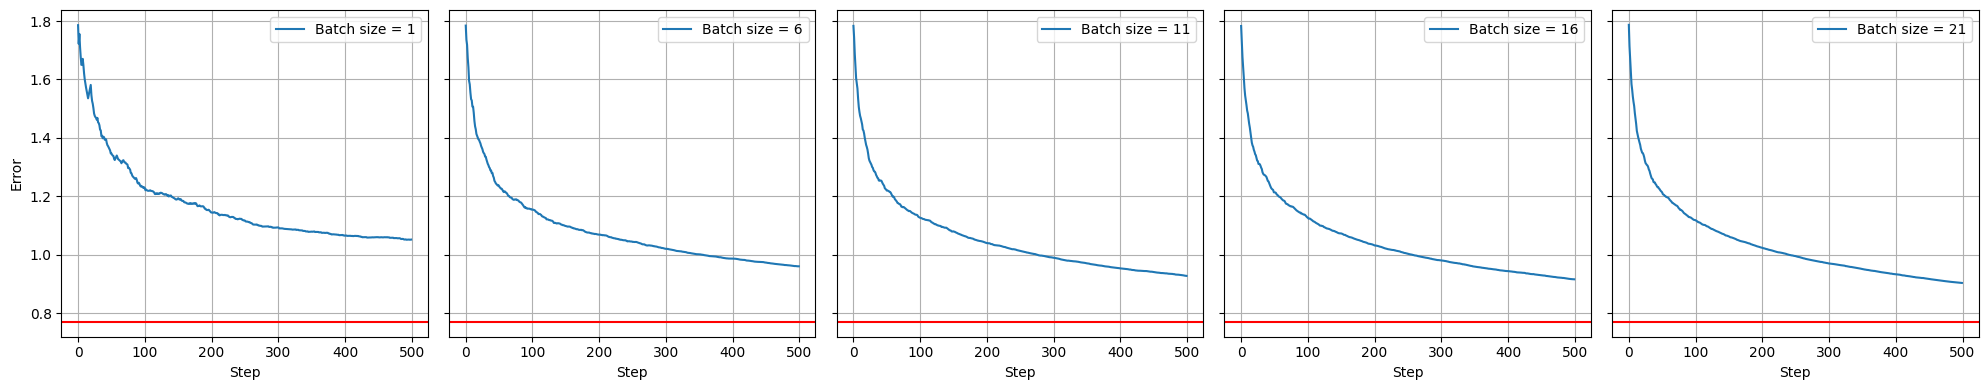

In [86]:
ratios = []
for batch_size in all_batch_size:

    # Generación de datos
    A, x, b = generate_data(n_filas, n_columnas)

    # Find alpha
    alpha = get_alpha(A)

    # Hiperparámetros
    Nsteps = 500

    fk = []
    r = np.zeros(n_columnas)

    # Iterate for each step
    for i_step in range(Nsteps):
        last_x = x.copy()

        # Iterate over each batch
        geval = np.zeros(n_columnas)
        for i_batch in range(batch_size):
            idx = np.random.choice(n_filas, size=1)
            ai, bi = A[idx], b[idx]
            pk = grad_f(ai, x, bi)
            geval = geval + pk
        geval = geval * 1/batch_size

        # Update variables
        r += geval**2
        adapt_lr = alpha/(np.sqrt(r)+.01)
        x = x - adapt_lr * geval

        # Compute error
        fk.append(error(A, x, b))

        # ratio = ||xk - x*|| / ||xk-1 - x*||
        distance_k = np.linalg.norm(x-x_star)
        distance_k_minus_1 = np.linalg.norm(last_x-x_star)
        ratios.append({'batch_size':batch_size, 'step':i_step, 'ratio': distance_k / distance_k_minus_1, 'delta': distance_k - distance_k_minus_1, 'error':error(A, x, b)})
ratios = pd.DataFrame(ratios)
convergencias_adagrad = ratios.copy()

# Plots
n = len(all_batch_size)

### A medida que aumenta batch size, disminuye la variabilidad de la convergencia.
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(4*n, 4), sharey=True)
for ax, batch_size in zip(axes, all_batch_size):
    data = (ratios
            .query('batch_size == @batch_size')
            .set_index('step')
            .ratio)
    ax.plot(data, label=f"Batch size = {batch_size}")
    ax.set_xlabel('Step')
    if ax is axes[0]:
        ax.set_ylabel('||xₖ - x*|| / ||xₖ₋₁ - x*||')
    ax.legend()
    ax.grid()
    # ax.set_ylim(.95, 1.05)

plt.tight_layout()
plt.show()

### A medida que aumenta batch size, converge más rápido.
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(4*n, 4), sharey=True)
for ax, batch_size in zip(axes, all_batch_size):
    data = (ratios
            .query('batch_size == @batch_size')
            .set_index('step')
            .error)
    ax.plot(data, label=f"Batch size = {batch_size}")
    ax.set_xlabel('Step')
    if ax is axes[0]:
        ax.set_ylabel('Error')
    ax.legend()
    ax.grid()
    ax.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
    # ax.set_ylim(.95, 1.05)

plt.tight_layout()
plt.show()

### b) RMSProp

In [87]:
# Generación de datos
A, x, b = generate_data(n_filas, n_columnas)

# Hiperparámetros
Nsteps = 500
batch_size = 3
beta = 0.9

# Find alpha
alpha = get_alpha(A)

# Init variables
r = np.zeros(n_columnas)
fk = []

# Iterate for each step
for i_step in range(Nsteps):

    # Iterate over each batch
    geval = np.zeros(n_columnas)
    for i_batch in range(batch_size):
        idx = np.random.choice(n_filas, size=1)
        ai, bi = A[idx], b[idx]
        pk = grad_f(ai, x, bi)
        geval = geval + pk
    geval = geval * 1/batch_size

    # Update variables
    r = beta*r + (1-beta)*geval**2
    adapt_lr = alpha/(np.sqrt(r)+1e-8)
    x = x - adapt_lr * geval

    # Compute error
    fk.append(error(A, x, b))

print('Error: ', error(A, x, b))
print('Norma de a: ', np.sqrt(sum(x**2)))

Error:  0.7740240423356209
Norma de a:  0.4832566044170173


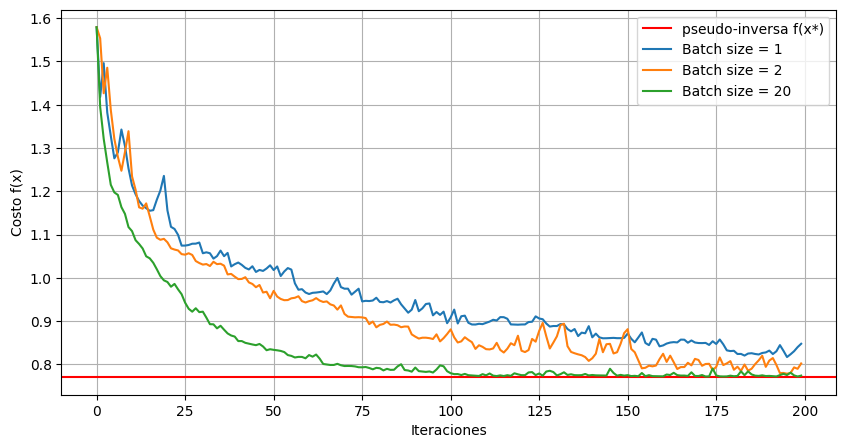

In [88]:
#### Dibujito

all_batch_sizes = [1, 2, 20]

convergencias = []
for batch_size in all_batch_sizes:

    # Generación de datos
    A, x, b = generate_data(n_filas, n_columnas)

    # Hiperparámetros
    Nsteps = 200
    beta = .9

    # Find alpha
    alpha = get_alpha(A)

    # Init variables
    r = np.zeros(n_columnas)
    fk = []

    # Iterate for each step
    for i_step in range(Nsteps):

        # Iterate over each batch
        geval = np.zeros(n_columnas)
        for i_batch in range(batch_size):
            idx = np.random.choice(n_filas, size=1)
            ai, bi = A[idx], b[idx]
            pk = grad_f(ai, x, bi)
            geval = geval + pk
        geval = geval * 1/batch_size

        # Update variables
        r = beta*r + (1-beta)*geval**2
        adapt_lr = alpha/(np.sqrt(r)+1e-8)
        x = x - adapt_lr * geval

        # Compute error
        fk.append(error(A, x, b))

        convergencias.append({'batch_size': batch_size, 'step':i_step, 'error': fk[-1]})

convergencias = pd.DataFrame(convergencias)

plt.figure(figsize=(10, 5))
plt.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
plt.plot(convergencias.query('batch_size==1').reset_index().error, label="Batch size = 1")
plt.plot(convergencias.query('batch_size==2').reset_index().error, label="Batch size = 2")
plt.plot(convergencias.query('batch_size==20').reset_index().error, label="Batch size = 20")
plt.xlabel('Iteraciones')
plt.ylabel('Costo f(x)')
plt.legend()
plt.grid()
plt.show()

a.3) Estudie como varia la tasa de convergencia comparando los ratios ∥xk+1 − x∗∥/∥xk − x∗∥ para distintos tamaños de minibatches.

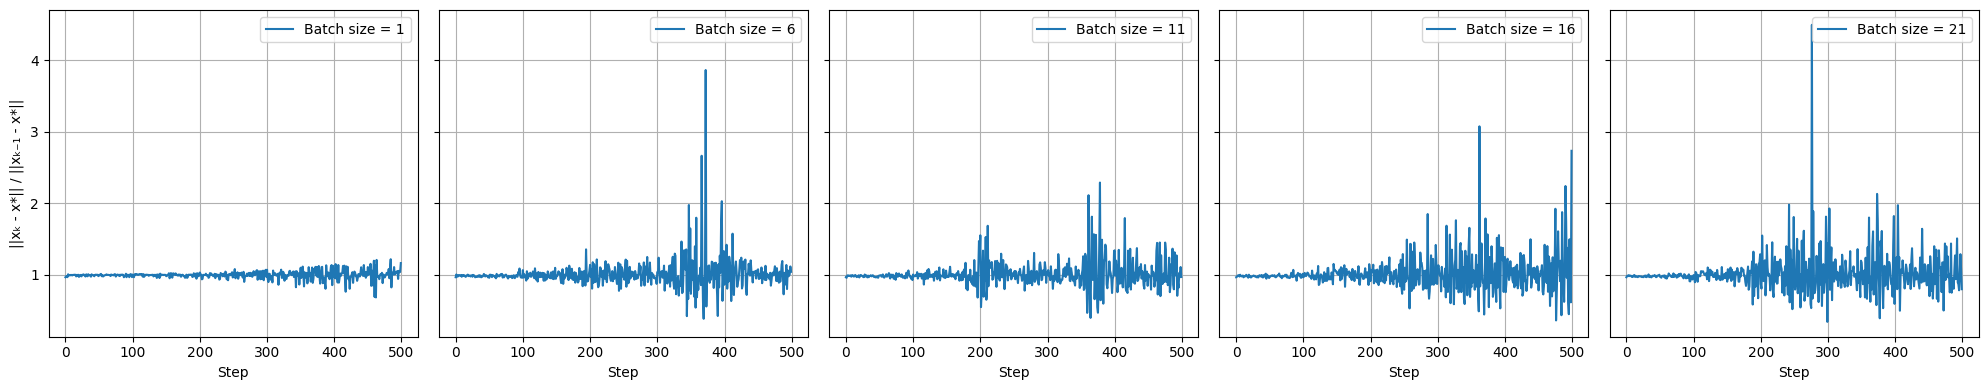

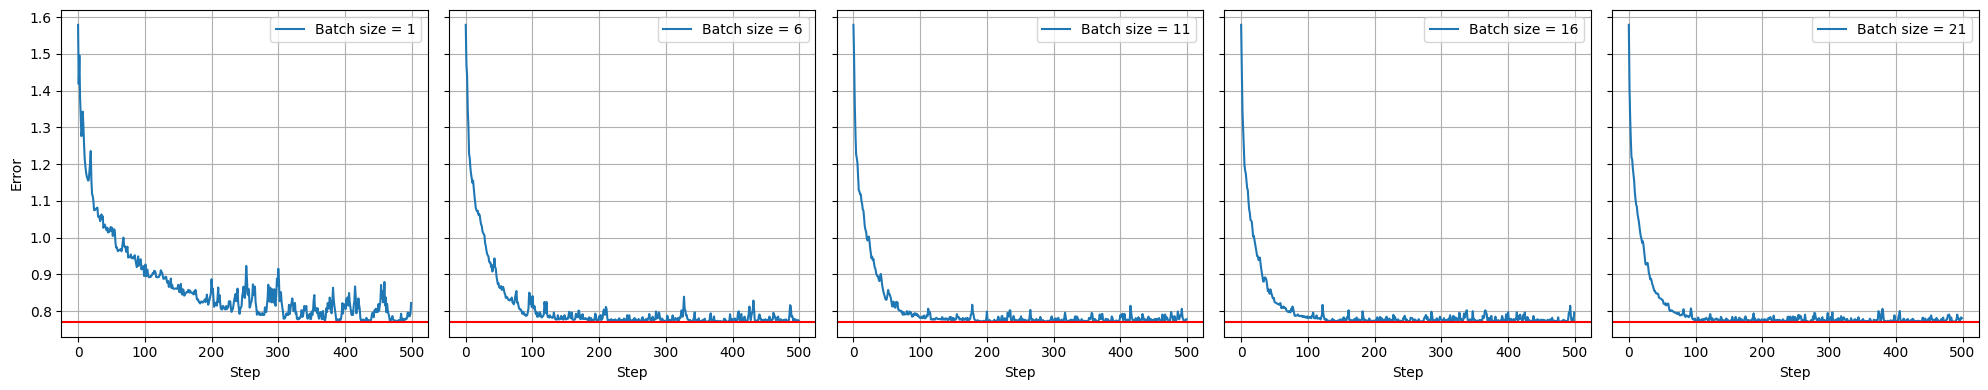

In [89]:
# Hiperparámetros
Nsteps = 500
beta = .9

ratios = []
for batch_size in all_batch_size:

    # Generación de datos
    A, x, b = generate_data(n_filas, n_columnas)

    # Find alpha
    alpha = get_alpha(A)

    # Init variables
    r = np.zeros(n_columnas)
    fk = []

    # Iterate for each step
    for i_step in range(Nsteps):
        last_x = x.copy()

        # Iterate over each batch
        geval = np.zeros(n_columnas)
        for i_batch in range(batch_size):
            idx = np.random.choice(n_filas, size=1)
            ai, bi = A[idx], b[idx]
            pk = grad_f(ai, x, bi)
            geval = geval + pk
        geval = geval * 1/batch_size

        # Update variables
        r = beta*r + (1-beta)*geval**2
        adapt_lr = alpha/(np.sqrt(r)+1e-8)
        x = x - adapt_lr * geval

        # Compute error
        fk.append(error(A, x, b))

        # ratio = ||xk - x*|| / ||xk-1 - x*||
        distance_k = np.linalg.norm(x-x_star)
        distance_k_minus_1 = np.linalg.norm(last_x-x_star)
        ratios.append({'batch_size':batch_size, 'step':i_step, 'ratio': distance_k / distance_k_minus_1, 'delta': distance_k - distance_k_minus_1, 'error':error(A, x, b)})
ratios = pd.DataFrame(ratios)
convergencias_rmsprop = ratios.copy()

# Plots
n = len(all_batch_size)

### A medida que aumenta batch size, disminuye la variabilidad de la convergencia.
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(4*n, 4), sharey=True)
for ax, batch_size in zip(axes, all_batch_size):
    data = (ratios
            .query('batch_size == @batch_size')
            .set_index('step')
            .ratio)
    ax.plot(data, label=f"Batch size = {batch_size}")
    ax.set_xlabel('Step')
    if ax is axes[0]:
        ax.set_ylabel('||xₖ - x*|| / ||xₖ₋₁ - x*||')
    ax.legend()
    ax.grid()
    # ax.set_ylim(.95, 1.05)

plt.tight_layout()
plt.show()

### A medida que aumenta batch size, converge más rápido.
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(4*n, 4), sharey=True)
for ax, batch_size in zip(axes, all_batch_size):
    data = (ratios
            .query('batch_size == @batch_size')
            .set_index('step')
            .error)
    ax.plot(data, label=f"Batch size = {batch_size}")
    ax.set_xlabel('Step')
    if ax is axes[0]:
        ax.set_ylabel('Error')
    ax.legend()
    ax.grid()
    ax.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
    # ax.set_ylim(.95, 1.05)

plt.tight_layout()
plt.show()

### c) ADAM

In [90]:
def generate_data(n_filas, n_columnas):
    np.random.seed(0)
    A = np.random.rand(n_filas, n_columnas)    # Datos
    x = np.random.rand(n_columnas)             # betas
    b = np.random.rand(n_filas)                # labels
    return A, x, b

# Generación de datos
A, x, b = generate_data(n_filas, n_columnas)

# Hiperparámetros
Nsteps = 500
batch_size = 3
beta_1 = 0.9
beta_2 = 0.9

alpha = 1e-2

# Init variables
r = np.zeros(n_columnas)
s = np.zeros(n_columnas)
fk = []

# Iterate for each step
for i_step in range(Nsteps):

    # Iterate over each batch
    geval = np.zeros(n_columnas)
    for i_batch in range(batch_size):
        idx = np.random.choice(n_filas, size=1)
        ai, bi = A[idx], b[idx]
        pk = grad_f(ai, x, bi)
        geval = geval + pk
    geval = geval * 1/batch_size

    # Update variables
    s = beta_1*s + (1-beta_1)*geval
    r = beta_2*r + (1-beta_2)*(geval**2)
    s_hat = s/(1-beta_1**i_step)
    r_hat = r/(1-beta_2**i_step)
    adapt_lr = alpha*s_hat/(np.sqrt(r_hat)+1e-8)
    x = x - adapt_lr

/var/folders/_r/157z0l_91ps9f7pvx9d8nf0c0000gn/T/ipykernel_6189/3955407624.py:39: RuntimeWarning: divide by zero encountered in divide
  s_hat = s/(1-beta_1**i_step)
/var/folders/_r/157z0l_91ps9f7pvx9d8nf0c0000gn/T/ipykernel_6189/3955407624.py:40: RuntimeWarning: divide by zero encountered in divide
  r_hat = r/(1-beta_2**i_step)
/var/folders/_r/157z0l_91ps9f7pvx9d8nf0c0000gn/T/ipykernel_6189/3955407624.py:41: RuntimeWarning: invalid value encountered in divide
  adapt_lr = alpha*s_hat/(np.sqrt(r_hat)+1e-8)


In [91]:
# Generación de datos
A, x, b = generate_data(n_filas, n_columnas)

# Hiperparámetros
Nsteps = 500
batch_size = 3
beta_1 = 0.9
beta_2 = 0.9

# Find alpha
alpha = get_alpha(A)

# Init variables
r = np.zeros(n_columnas)
s = np.zeros(n_columnas)
fk = []

# Iterate for each step
for i_step in range(1, Nsteps+1):

    # Iterate over each batch
    geval = np.zeros(n_columnas)
    for i_batch in range(batch_size):
        idx = np.random.choice(n_filas, size=1)
        ai, bi = A[idx], b[idx]
        pk = grad_f(ai, x, bi)
        geval = geval + pk
    geval = geval * 1/batch_size

    # Update variables
    s = beta_1*s + (1-beta_1)*geval
    r = beta_2*r + (1-beta_2)*(geval**2)
    s_hat = s/(1-beta_1**i_step)
    r_hat = r/(1-beta_2**i_step)
    adapt_lr = alpha*s_hat/(np.sqrt(r_hat)+1e-8)
    x = x - adapt_lr

    # Compute error
    fk.append(error(A, x, b))

print('Error: ', error(A, x, b))
print('Norma de a: ', np.sqrt(sum(x**2)))

Error:  0.7729736984969043
Norma de a:  0.5028292805356318


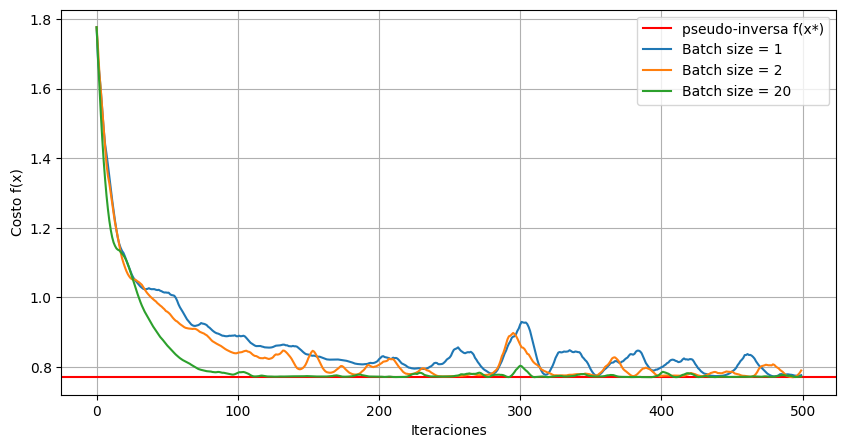

In [92]:
#### Dibujito

all_batch_sizes = [1, 2, 20]

convergencias = []
for batch_size in all_batch_sizes:
    
    # Generación de datos
    A, x, b = generate_data(n_filas, n_columnas)

    # Hiperparámetros
    Nsteps = 500
    beta_1 = 0.9
    beta_2 = 0.9

    # Find alpha
    alpha = get_alpha(A)

    # Init variables
    r = np.zeros(n_columnas)
    s = np.zeros(n_columnas)
    fk = []

    # Iterate for each step
    for i_step in range(1, Nsteps+1):

        # Iterate over each batch
        geval = np.zeros(n_columnas)
        for i_batch in range(batch_size):
            idx = np.random.choice(n_filas, size=1)
            ai, bi = A[idx], b[idx]
            pk = grad_f(ai, x, bi)
            geval = geval + pk
        geval = geval * 1/batch_size

        # Update variables
        s = beta_1*s + (1-beta_1)*geval
        r = beta_2*r + (1-beta_2)*(geval**2)
        s_hat = s/(1-beta_1**i_step)
        r_hat = r/(1-beta_2**i_step)
        adapt_lr = alpha*s_hat/(np.sqrt(r_hat)+1e-8)
        x = x - adapt_lr

        # Compute error
        fk.append(error(A, x, b))

        convergencias.append({'batch_size': batch_size, 'step':i_step, 'error': fk[-1]})

convergencias = pd.DataFrame(convergencias)

plt.figure(figsize=(10, 5))
plt.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
plt.plot(convergencias.query('batch_size==1').reset_index().error, label="Batch size = 1")
plt.plot(convergencias.query('batch_size==2').reset_index().error, label="Batch size = 2")
plt.plot(convergencias.query('batch_size==20').reset_index().error, label="Batch size = 20")
plt.xlabel('Iteraciones')
plt.ylabel('Costo f(x)')
plt.legend()
plt.grid()
plt.show()

a.3) Estudie como varia la tasa de convergencia comparando los ratios ∥xk+1 − x∗∥/∥xk − x∗∥ para distintos tamaños de minibatches.

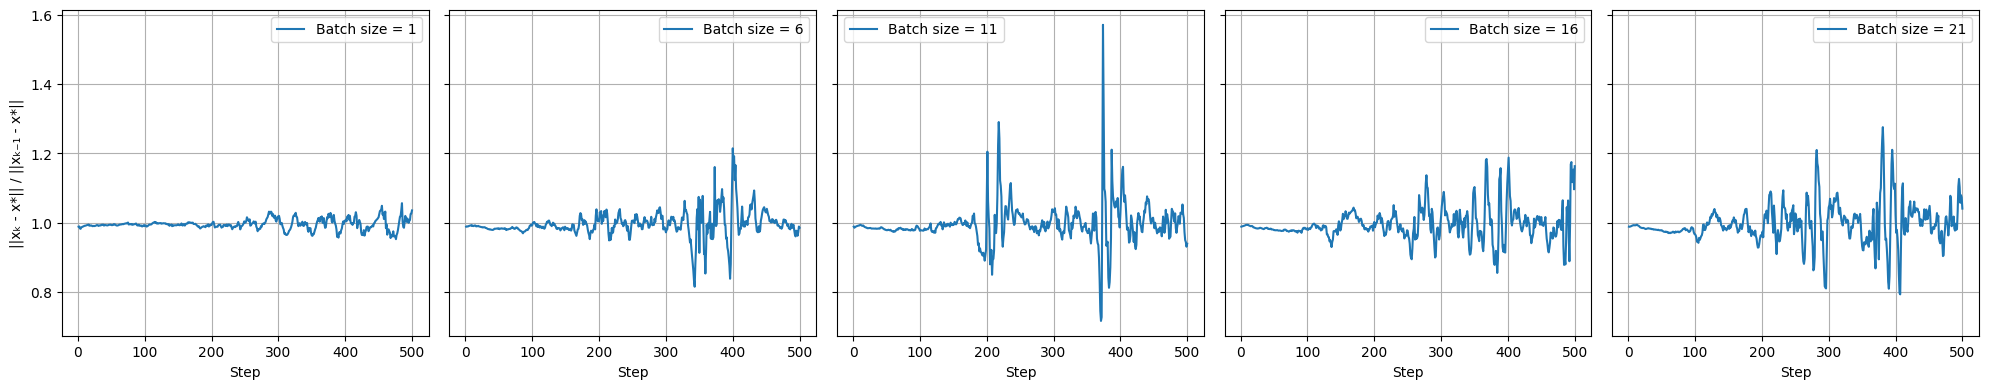

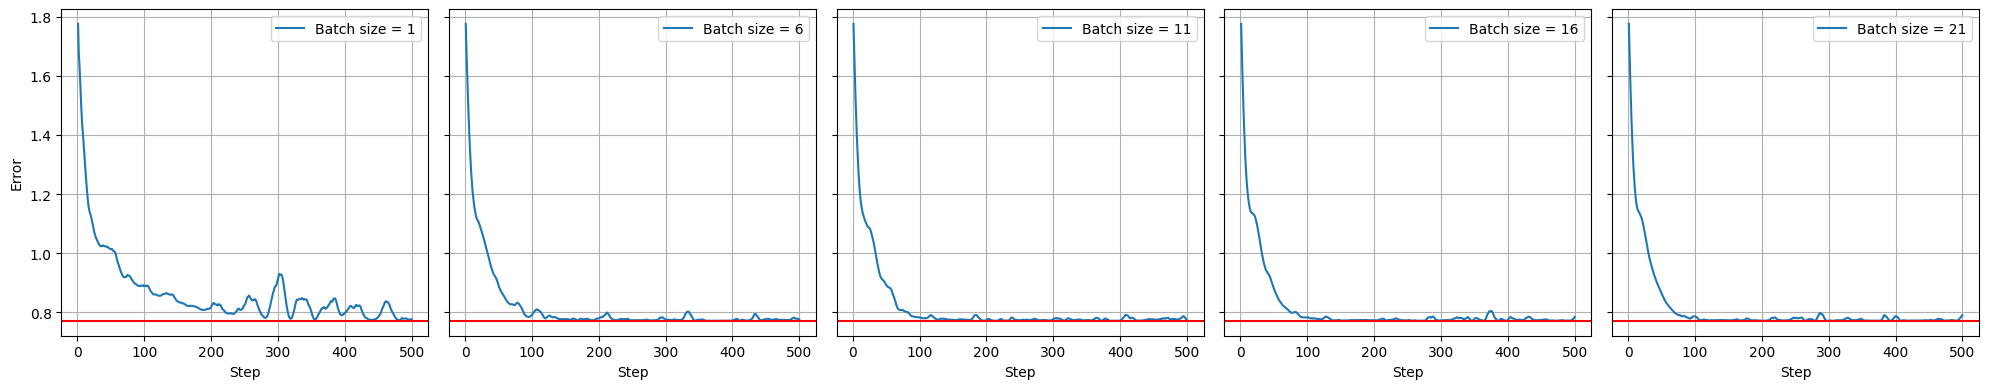

In [93]:
# Hiperparámetros
Nsteps = 500
beta_1 = 0.9
beta_2 = 0.9

# Find alpha
alpha = get_alpha(A)

ratios = []
for batch_size in all_batch_size:

    # Generación de datos
    A, x, b = generate_data(n_filas, n_columnas)

    # Init variables
    r = np.zeros(n_columnas)
    s = np.zeros(n_columnas)
    fk = []

    # Iterate for each step
    for i_step in range(1, Nsteps+1):
        last_x = x.copy()

        # Iterate over each batch
        geval = np.zeros(n_columnas)
        for i_batch in range(batch_size):
            idx = np.random.choice(n_filas, size=1)
            ai, bi = A[idx], b[idx]
            pk = grad_f(ai, x, bi)
            geval = geval + pk
        geval = geval * 1/batch_size

        # Update variables
        s = beta_1*s + (1-beta_1)*geval
        r = beta_2*r + (1-beta_2)*(geval**2)
        s_hat = s/(1-beta_1**i_step)
        r_hat = r/(1-beta_2**i_step)
        adapt_lr = alpha*s_hat/(np.sqrt(r_hat)+1e-8)
        x = x - adapt_lr

        # Compute error
        fk.append(error(A, x, b))

        # ratio = ||xk - x*|| / ||xk-1 - x*||
        distance_k = np.linalg.norm(x-x_star)
        distance_k_minus_1 = np.linalg.norm(last_x-x_star)
        ratios.append({'batch_size':batch_size, 'step':i_step, 'ratio': distance_k / distance_k_minus_1, 'delta': distance_k - distance_k_minus_1, 'error':error(A, x, b)})
ratios = pd.DataFrame(ratios)
convergencias_adam = ratios.copy()

# Plots
n = len(all_batch_size)

### A medida que aumenta batch size, disminuye la variabilidad de la convergencia.
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(4*n, 4), sharey=True)
for ax, batch_size in zip(axes, all_batch_size):
    data = (ratios
            .query('batch_size == @batch_size')
            .set_index('step')
            .ratio)
    ax.plot(data, label=f"Batch size = {batch_size}")
    ax.set_xlabel('Step')
    if ax is axes[0]:
        ax.set_ylabel('||xₖ - x*|| / ||xₖ₋₁ - x*||')
    ax.legend()
    ax.grid()
    # ax.set_ylim(.95, 1.05)

plt.tight_layout()
plt.show()

### A medida que aumenta batch size, converge más rápido.
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(4*n, 4), sharey=True)
for ax, batch_size in zip(axes, all_batch_size):
    data = (ratios
            .query('batch_size == @batch_size')
            .set_index('step')
            .error)
    ax.plot(data, label=f"Batch size = {batch_size}")
    ax.set_xlabel('Step')
    if ax is axes[0]:
        ax.set_ylabel('Error')
    ax.legend()
    ax.grid()
    ax.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
    # ax.set_ylim(.75, 1.25)

plt.tight_layout()
plt.show()

# COMPARACION TODOS CON TODOS

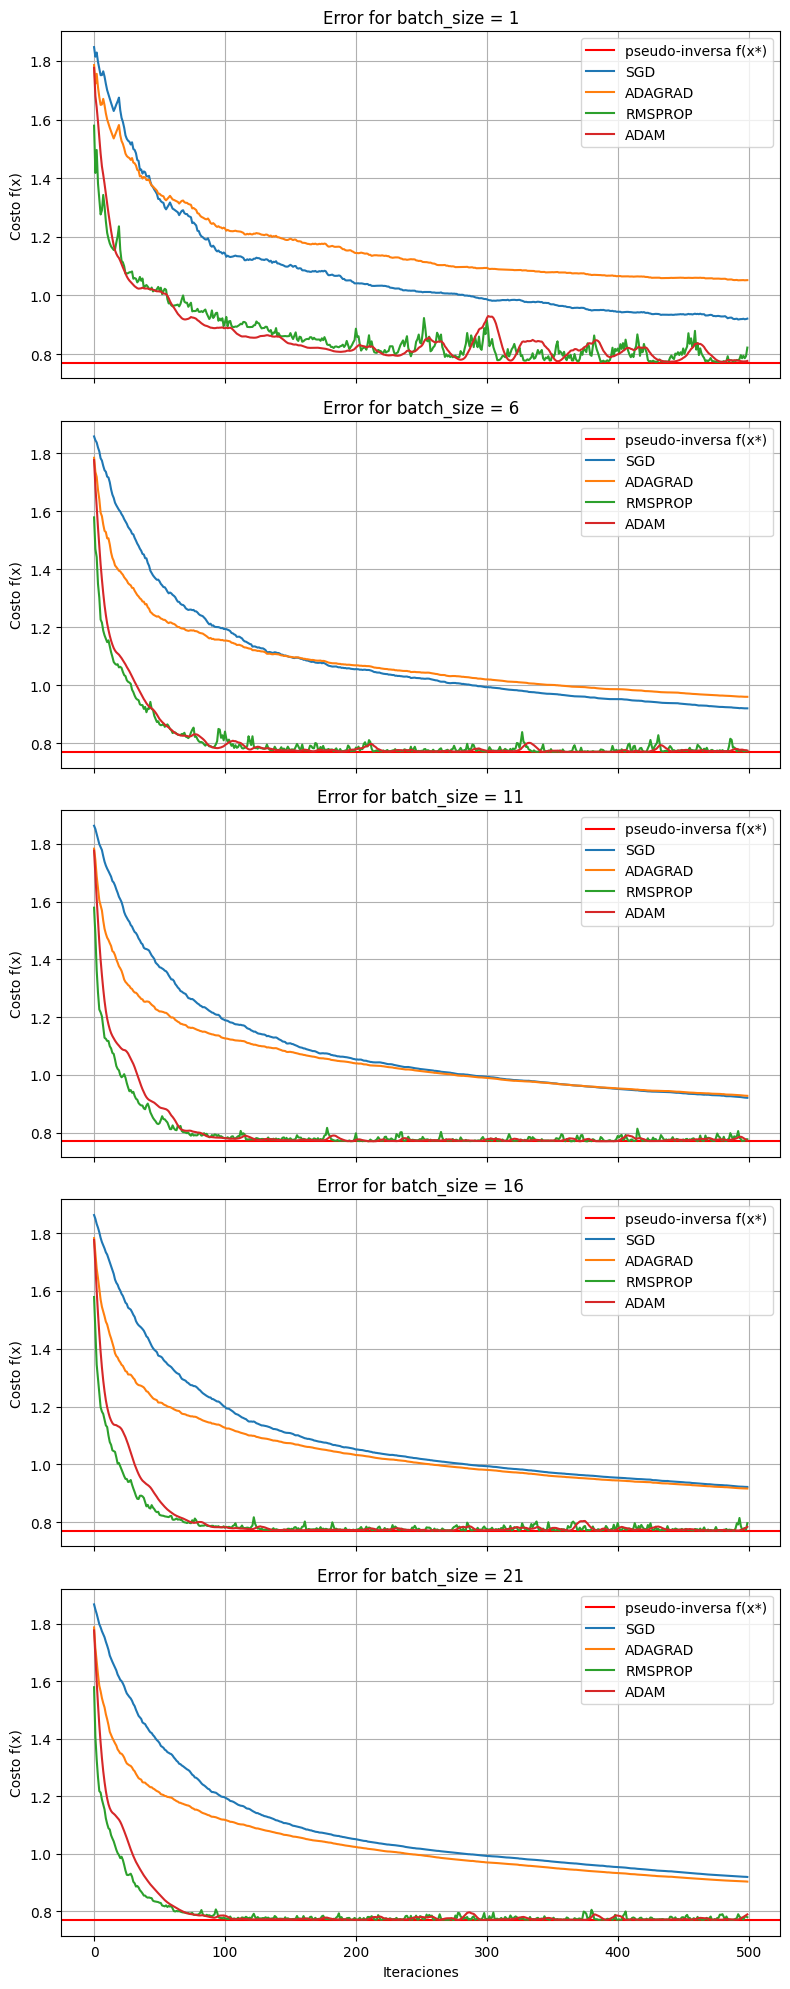

In [94]:
# Generación de datos
A, x, b = generate_data(n_filas, n_columnas)

all_batch_size = list(range(1, n_filas+2, 5))
n = len(all_batch_size)

fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 4*n), sharex=True)

for ax, batch_size in zip(axes, all_batch_size):
    # Baseline from pseudoinverse
    ax.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
    
    # Plot each optimizer's convergence
    ax.plot(convergencias_sgd.query('batch_size==@batch_size').reset_index().error, label="SGD")
    ax.plot(convergencias_adagrad.query('batch_size==@batch_size').reset_index().error, label="ADAGRAD")
    ax.plot(convergencias_rmsprop.query('batch_size==@batch_size').reset_index().error, label="RMSPROP")
    ax.plot(convergencias_adam.query('batch_size==@batch_size').reset_index().error, label="ADAM")

    ax.set_title(f'Error for batch_size = {batch_size}')
    ax.set_ylabel('Costo f(x)')
    ax.legend(loc='upper right')
    ax.grid(True)
    # ax.set_ylim(0,14)

axes[-1].set_xlabel('Iteraciones')

plt.tight_layout()
plt.show()

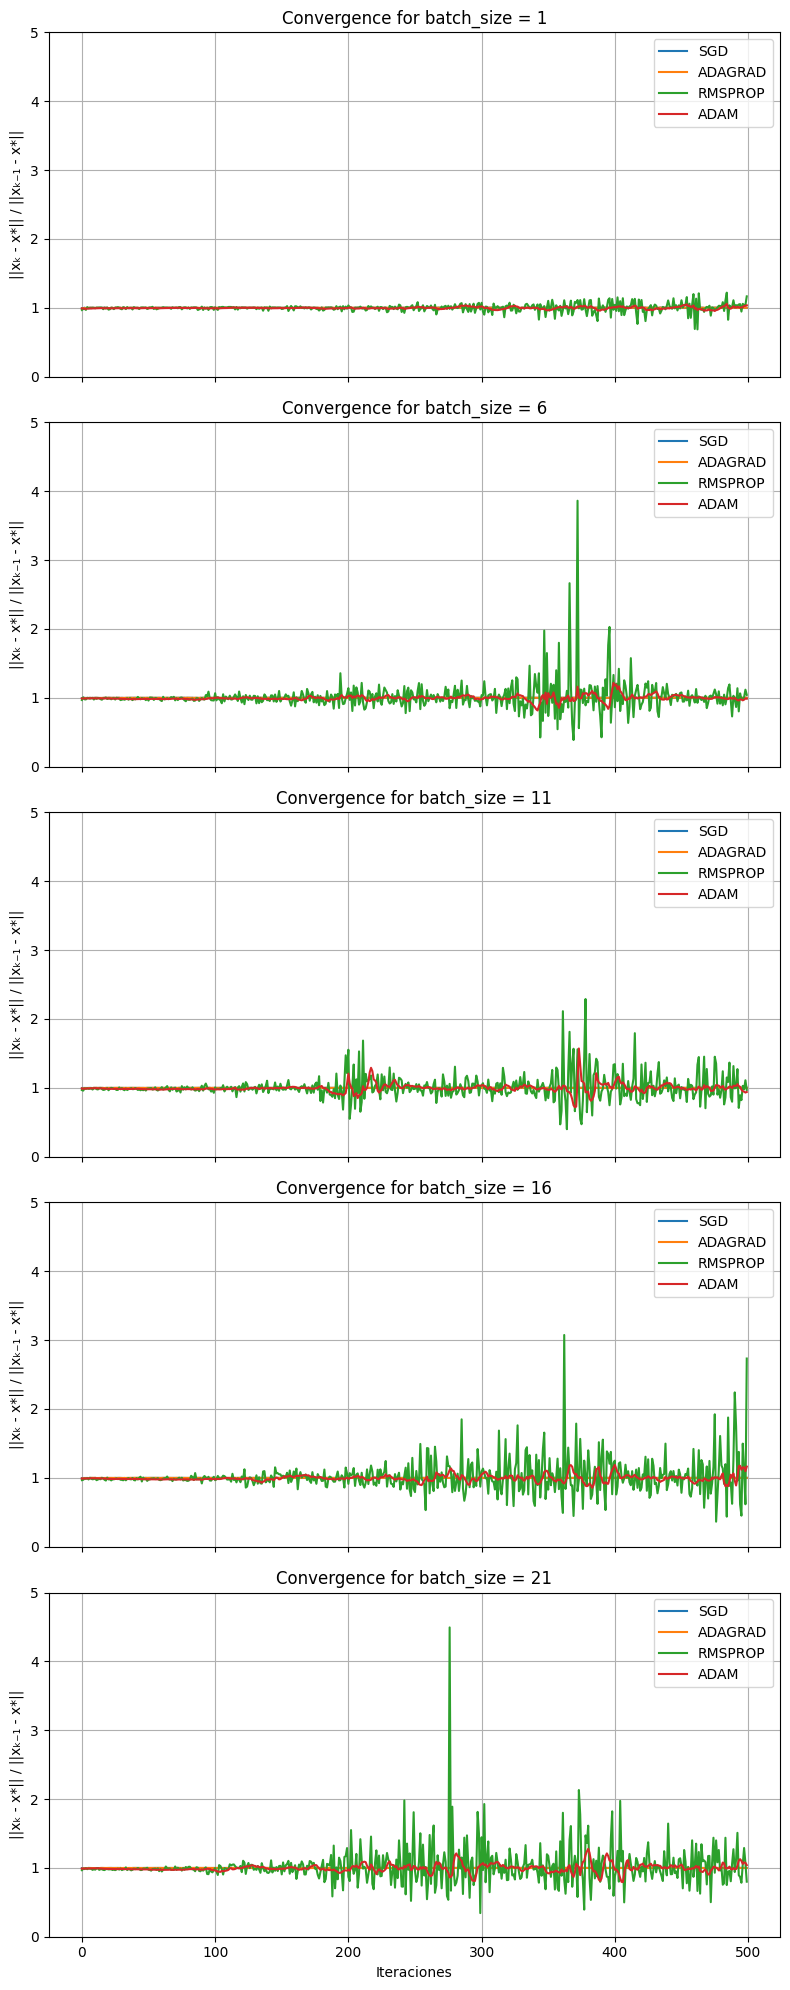

In [95]:
# Generación de datos
A, x, b = generate_data(n_filas, n_columnas)

all_batch_size = list(range(1, n_filas+2, 5))
n = len(all_batch_size)

fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 4*n), sharex=True)

for ax, batch_size in zip(axes, all_batch_size):
    # Baseline from pseudoinverse
    # ax.axhline(error(A, x_star, b), color='r', linestyle='-', label='pseudo-inversa f(x*)')
    
    # Plot each optimizer's convergence
    ax.plot(convergencias_sgd.query('batch_size==@batch_size').reset_index().ratio, label="SGD")
    ax.plot(convergencias_adagrad.query('batch_size==@batch_size').reset_index().ratio, label="ADAGRAD")
    ax.plot(convergencias_rmsprop.query('batch_size==@batch_size').reset_index().ratio, label="RMSPROP")
    ax.plot(convergencias_adam.query('batch_size==@batch_size').reset_index().ratio, label="ADAM")

    ax.set_title(f'Convergence for batch_size = {batch_size}')
    ax.set_ylabel('||xₖ - x*|| / ||xₖ₋₁ - x*||')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_ylim(0,5)

axes[-1].set_xlabel('Iteraciones')

plt.tight_layout()
plt.show()